# Normal Crossing RLCT Estimation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/normal_crossing.ipynb)

This notebook measures the RLCT of normal crossings using two algorithms: SGNHT (Stochastic Gradient Nose-Hoover Thermostat) and SGLD (Stochastic Gradient Langevin Dynamics). The target model is a polynomial model characterized by $w_1^a * w_2^b$ for some $(a, b)$, where $w_1$ and $w_2$ are weights to be learned. The data is generated with gaussian noise around the origin, so the model achieves its lowest loss when $w_1=0$ or $w_2 =0$. We first estimate the RLCTs from different points of weight space. Then, we plot some sampled trajectories, and do a quick reproduction of Table 1 of [Lau et al. (2023)](https://arxiv.org/pdf/2308.12108.pdf).

In [1]:
%pip install devinterp matplotlib pyro-ppl seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import seaborn as sns
import torch
from torch.optim.sgd import SGD
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgld_ma import SGLD_MA
from devinterp.optim.sgnht import SGNHT
from devinterp.slt import estimate_learning_coeff, sample

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_style("whitegrid")

# plotting
CMAP = sns.color_palette("muted", as_cmap=True)
PRIMARY, SECONDARY, TERTIARY = CMAP[:3]

In [3]:
# constants
SIGMA = 0.25
NUM_TRAIN_SAMPLES = 1000
BATCH_SIZE = NUM_TRAIN_SAMPLES
CRITERION = F.mse_loss

In [4]:
# some necessary functions
class PolyModel(nn.Module):
    def __init__(self, powers):
        super(PolyModel, self).__init__()
        self.weights = nn.Parameter(
            torch.tensor([1.0, 0.3], dtype=torch.float32, requires_grad=True)
        )
        self.powers = powers

    def forward(self, x):
        multiplied = torch.prod(self.weights**self.powers)
        x = x * multiplied
        return x


def generate_dataset_for_seed(seed=0):
    x = torch.normal(0, 2, size=(NUM_TRAIN_SAMPLES,))
    y = SIGMA * torch.normal(0, 1, size=(NUM_TRAIN_SAMPLES,))
    train_data = TensorDataset(x, y)
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    return train_loader, train_data, x, y


def estimate_rlct_helper(model, train_loader, criterion, optimizer_kwargs, sampling_method, device):
    return estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion,
        optimizer_kwargs=optimizer_kwargs,
        sampling_method=sampling_method,
        num_chains=5,
        num_draws=1000,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        verbose=True,
        device=device,
    )


def get_rlcts(
    train_loader,
    train_data,
    weights=[0.0, 0.0],
    lr=0.0005,
    powers=torch.tensor([1, 2]).to(DEVICE),
    n_estimates=10,
    return_results_dict=True,
):
    model = PolyModel(powers).to(DEVICE)
    model.weights = nn.Parameter(torch.tensor(weights, dtype=torch.float32, requires_grad=True))
    rlct_estimates_sgnht, rlct_estimates_sgld = [], []

    sgnht_kwargs = {
        "lr": lr,
        "diffusion_factor": 0.01,
        "bounding_box_size": 0.5,
        "num_samples": len(train_data),
    }
    sgld_kwargs = {
        "lr": lr,
        "elasticity": 1.0,
        "temperature": "adaptive",
        "num_samples": len(train_data),
    }
    for _ in range(n_estimates):
        rlct_sgnht = estimate_rlct_helper(
            model, train_loader, CRITERION, sgnht_kwargs, SGNHT, DEVICE
        )
        rlct_sgld = estimate_rlct_helper(model, train_loader, CRITERION, sgld_kwargs, SGLD_MA, DEVICE)
        if not math.isnan(rlct_sgnht):
            rlct_estimates_sgnht.append(rlct_sgnht)
        if not math.isnan(rlct_sgld):
            rlct_estimates_sgld.append(rlct_sgld)

    if return_results_dict:
        return {
            "weights": weights,
            "lr": lr,
            "powers": powers,
            "n_estimates": n_estimates,
            "rlct_estimates_sgnht": rlct_estimates_sgnht,
            "rlct_estimates_sgld": rlct_estimates_sgld,
        }
    else:
        return rlct_estimates_sgnht, rlct_estimates_sgld


def plot_rlcts(estimated_rlcts, sample_points, actual_rlcts):
    fig, axes = plt.subplots(1, len(estimated_rlcts), figsize=(14, 3))
    fig.patch.set_facecolor("white")
    for i, (rlct_estimates_sgnht, rlct_estimates_sgld) in enumerate(estimated_rlcts):
        axes[i].set_xlim([-0.5, 1.5])
        axes[i].set_title(rf"$w_1={sample_points[i][0]:.1f}, w_2={sample_points[i][1]:.1f}$")
        axes[i].hist(
            rlct_estimates_sgnht,
            alpha=0.6,
            bins=20,
            range=(-0.5, 1.5),
            label="SGNHT",
            color=PRIMARY,
        )
        axes[i].hist(
            rlct_estimates_sgld,
            alpha=0.6,
            bins=20,
            range=(-0.5, 1.5),
            label="SGLD",
            color=SECONDARY,
        )
        axes[i].axvline(actual_rlcts[i], color="black", linestyle="--")
        axes[i].set_xlabel(r"$\hat\lambda$")
    axes[0].legend()
    plt.show()

# Benchmarking

First, let's estimate some RLCTs of a simple normal crossing for $(a, b) = (1, 2)$. We first estimate the RLCTs at the origin, near the origin, and at points where either $w_1=0$ or $w_2=0$ (but not both). This is similar to Figure 1 from [Lau et al. (2023)](https://arxiv.org/pdf/2308.12108.pdf).

In [5]:
train_loader, train_data, x, y = generate_dataset_for_seed(0)

sample_points = [[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [0.1, 0.1]]
actual_rlcts = [0.25, 0.25, 0.5, 0.25]
estimated_rlcts = [
    get_rlcts(
        train_loader, train_data, weights=sample_point, n_estimates=20, return_results_dict=False
    )
    for sample_point in sample_points
]

Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 4997.88it/s]


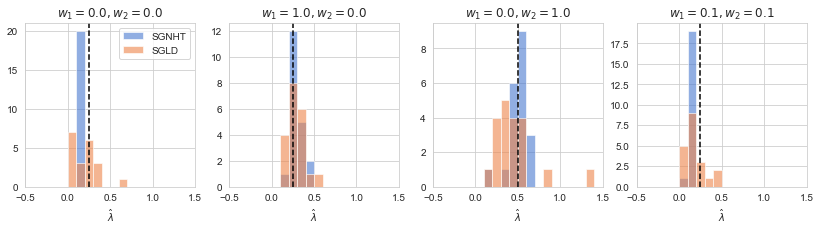

In [6]:
plot_rlcts(estimated_rlcts, sample_points, actual_rlcts)

# Trajectory Plots

Let's see how well our different sampling methods explore the local loss landscape. We start out sampling at $w_1 = 0.5, w_2 = 0.01$, and plot the resulting trajectories after 10k steps.

In [7]:
# plotting
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i : i + 2], 16) / 255.0 for i in (0, 2, 4))


lighter_factor = 0.9  # Between 0 and 1, higher values make it closer to white
lighter_SECONDARY = tuple([x + (1 - x) * lighter_factor for x in hex_to_rgb(SECONDARY)[:3]] + [1.0])

colors = [SECONDARY, lighter_SECONDARY]
n_bins = 20  # Number of bins
contour_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)

powers = torch.tensor([1, 2]).to(DEVICE)
model = PolyModel(powers).to(DEVICE)


def plot_trajectories(trajectories, names, device=DEVICE):
    """Sampled w1, w2 values are plotted on the contour plot of the loss function."""
    fig, axes = plt.subplots(1, len(trajectories), figsize=(14, 6))
    w1_range = np.linspace(-2, 2, 21)
    w2_range = np.linspace(-2, 2, 21)
    w1_vals, w2_vals = np.meshgrid(w1_range, w2_range)
    Z = np.zeros_like(w1_vals, dtype=float)

    for i in range(w1_vals.shape[0]):
        for j in range(w1_vals.shape[1]):
            w1 = w1_vals[i, j]
            w2 = w2_vals[i, j]
            model.weights = nn.Parameter(torch.tensor([w1, w2], dtype=torch.float32).to(device))
            Z[i, j] = (
                model.to(device)(torch.tensor(1.0).to(device)).item() ** 2
            )  # MSE, so square this

    custom_levels = np.linspace(Z.min(), Z.max() * 0.04, n_bins)

    for i, trajectory in enumerate(trajectories):
        axes[i].contourf(w1_vals, w2_vals, Z, levels=custom_levels, cmap=contour_cmap, alpha=0.8)
        weights = trajectory["model_weights"]
        draws_array = np.array(
            [
                d.detach().cpu().numpy()
                for d in weights
                if w1_range[0] <= d[0] <= w1_range[-1] and w2_range[0] <= d[1] <= w2_range[-1]
            ]
        )
        sns.scatterplot(
            x=draws_array[:, 0],
            y=draws_array[:, 1],
            marker="x",
            ax=axes[i],
            s=10,
            color=PRIMARY,
        )
        axes[i].axhline(0, linestyle="--", color="gray")
        axes[i].axvline(0, linestyle="--", color="gray")
        axes[i].set_xlabel(r"$w_{1}$")
        axes[i].set_ylabel(r"$w_{2}$")
        axes[i].set_title(names[i])
        axes[i].grid(False)
    plt.show()

In [8]:
train_loader, train_data, x, y = generate_dataset_for_seed(0)

In [9]:
torch.manual_seed(0)
np.random.seed(0)
model.weights = nn.Parameter(
    torch.tensor([0.5, 0.01], dtype=torch.float32, requires_grad=True).to(DEVICE)
)
lr = 0.0003
trace_sgnht = sample(
    model,
    train_loader,
    criterion=CRITERION,
    optimizer_kwargs=dict(
        lr=lr,
        diffusion_factor=0.01,
        num_samples=len(train_data),
    ),
    sampling_method=SGNHT,
    num_chains=1,
    num_draws=10_000,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=False,
    return_weights=True,
    device=DEVICE,
)
torch.manual_seed(0)
np.random.seed(0)
model.weights = nn.Parameter(
    torch.tensor([0.5, 0.01], dtype=torch.float32, requires_grad=True).to(DEVICE)
)
trace_sgld = sample(
    model,
    train_loader,
    criterion=CRITERION,
    optimizer_kwargs=dict(
        lr=lr,
        elasticity=1.0,
        temperature="adaptive",
        num_samples=len(train_data),
    ),
    sampling_method=SGLD,
    num_chains=1,
    num_draws=10_000,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=False,
    return_weights=True,
    device=DEVICE,
)

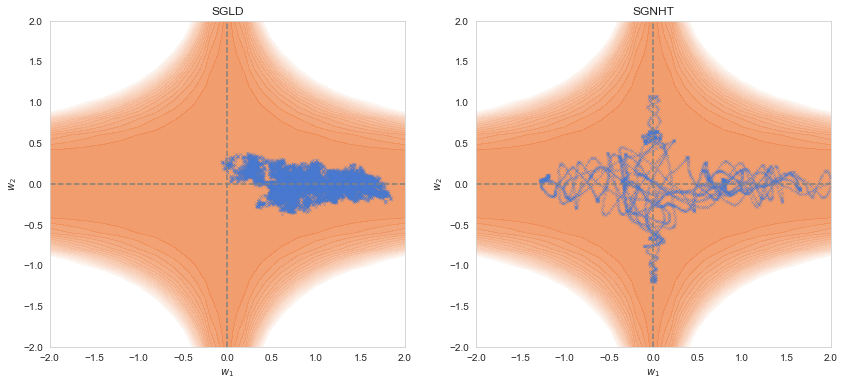

In [10]:
plot_trajectories([trace_sgld, trace_sgnht], names=["SGLD", "SGNHT"])

In [11]:
torch.manual_seed(0)
np.random.seed(0)
model.weights = nn.Parameter(
    torch.tensor([0.5, 0.01], dtype=torch.float32, requires_grad=True).to(DEVICE)
)
model = model.to(DEVICE)
model.powers = powers.to(DEVICE)

trace_sgd = sample(
    model,
    train_loader,
    criterion=CRITERION,
    optimizer_kwargs=dict(lr=1_000 * lr),
    sampling_method=SGD,
    num_chains=1,
    num_draws=10_000,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=False,
    return_weights=True,
    device=DEVICE,
)
torch.manual_seed(0)
np.random.seed(0)

model = model.to("cpu")
model.powers = powers.to("cpu")
# Define a Pyro model for Bayesian inference
w_prior = dist.Normal(model.weights, torch.ones_like(model.weights)).to_event(1)


def pyro_model(x, y):
    w = pyro.sample("weights", w_prior)
    model.weights = nn.Parameter(w.to("cpu"))
    y_pred = model(x.to("cpu"))
    pyro.sample("obs", dist.Normal(y_pred, 0.5), obs=y.to("cpu"))


# Perform MCMC sampling using NUTS
nuts_kernel = NUTS(pyro_model)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=20)
mcmc.run(x, y)


# Get posterior samples
posterior_samples = mcmc.get_samples()
trace_mcmc = {"model_weights": posterior_samples["weights"]}

model = model.to(DEVICE)
model.powers = powers.to(DEVICE)

Sample: 100%|██████████| 520/520 [00:04, 107.27it/s, step size=5.88e-01, acc. prob=0.290]


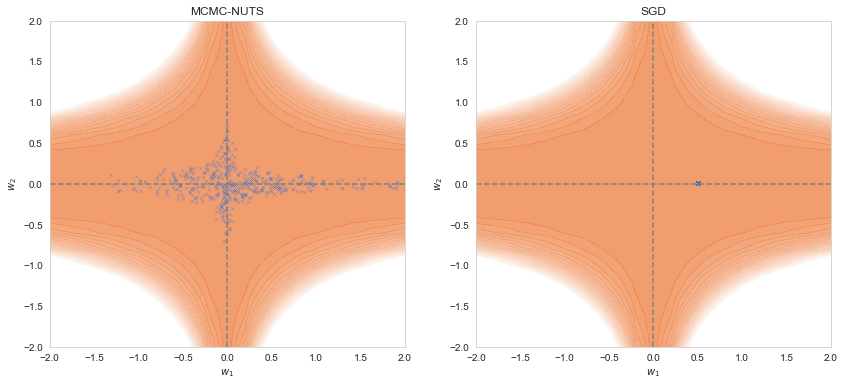

In [12]:
plot_trajectories([trace_mcmc, trace_sgd], names=["MCMC-NUTS", "SGD"])

# Benchmarking

Finally, let's check if we get the expected lambdahat values for a few different crossings. This is similar to Table 1 from [Lau et al. (2023)](https://arxiv.org/pdf/2308.12108.pdf).

In [13]:
n_seeds = 10
datasets = [generate_dataset_for_seed(seed) for seed in range(n_seeds)]
powers_to_test = [
    torch.tensor([1, 3]).to(DEVICE),
    torch.tensor([1, 2]).to(DEVICE),
    torch.tensor([0, 1]).to(DEVICE),
    torch.tensor([1, 0]).to(DEVICE),
    torch.tensor([1, 1]).to(DEVICE),
]
rlct_estimates = [
    get_rlcts(
        train_loader,
        train_data,
        lr=lr,
        powers=powers,
        n_estimates=1,
        return_results_dict=True,
    )
    for (train_loader, train_data, _, _) in datasets
    for powers in powers_to_test
    for lr in [0.0005, 0.001, 0.003]
]

Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 5114.82it/s]


In [14]:
df = pd.DataFrame.from_records(rlct_estimates)
df.drop("weights", axis=1, inplace=True)
df.drop("n_estimates", axis=1, inplace=True)
df["powers"] = df["powers"].apply(lambda x: tuple([tensor.tolist() for tensor in x]))
df["rlct_estimates_sgnht"] = df["rlct_estimates_sgnht"].apply(lambda x: x[0] if len(x) == 1 else x)
df["rlct_estimates_sgld"] = df["rlct_estimates_sgld"].apply(lambda x: x[0] if len(x) == 1 else x)
grouped = df.groupby(["lr", "powers"])[["rlct_estimates_sgnht", "rlct_estimates_sgld"]].agg(
    ["mean", "std"]
)
print(grouped)

              rlct_estimates_sgnht           rlct_estimates_sgld          
                              mean       std                mean       std
lr     powers                                                             
0.0005 (0, 1)             0.535312  0.083764            0.582938  0.056519
       (1, 0)             0.461463  0.085243            0.561266  0.051428
       (1, 1)             0.316952  0.082800            0.279923  0.108490
       (1, 2)             0.148680  0.018440            0.124762  0.063216
       (1, 3)             0.059216  0.014682            0.078136  0.081362
0.0010 (0, 1)             0.494249  0.063874            0.694539  0.043577
       (1, 0)             0.626638  0.098404            0.669216  0.025383
       (1, 1)             0.312248  0.047621            0.337627  0.118117
       (1, 2)             0.162590  0.023181            0.218068  0.070875
       (1, 3)             0.060915  0.014719            0.074232  0.045436
0.0030 (0, 1)            